# VRP Solver - Recuit Simulé

Résolution du Vehicle Routing Problem avec:
- Contraintes de capacité
- Métaheuristique: Simulated Annealing
- 3 heuristiques constructives
- 5 opérateurs de voisinage

## Imports et Configuration

In [60]:
import math
import random
import numpy as np
from copy import deepcopy
from typing import List, Tuple, Dict
import time

# Bibliothèques visualisation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import networkx as nx

random.seed(42)
np.random.seed(42)

# Paramètres Recuit Simulé
INITIAL_TEMPERATURE = 2000
COOLING_RATE = 0.999
MAX_ITERATIONS = 50000
MIN_TEMPERATURE = 0.1

print("Configuration chargée")
print(f"Paramètres SA: T0={INITIAL_TEMPERATURE}, alpha={COOLING_RATE}, iter={MAX_ITERATIONS}")
print("Bibliothèques: Plotly + NetworkX")

Configuration chargée
Paramètres SA: T0=2000, alpha=0.999, iter=50000
Bibliothèques: Plotly + NetworkX


## Classes de Base

In [61]:
class Client:
    def __init__(self, id: int, x: float, y: float, demand: int):
        self.id = id
        self.x = x
        self.y = y
        self.demand = demand
    
    def __repr__(self):
        return f"Client({self.id}, demand={self.demand})"


class Vehicle:
    def __init__(self, capacity: int, id: int = 0):
        self.id = id
        self.capacity = capacity
        self.route: List[Client] = []
        self.load = 0
    
    def add_client(self, client: Client) -> bool:
        if self.load + client.demand <= self.capacity:
            self.route.append(client)
            self.load += client.demand
            return True
        return False
    
    def remove_client(self, client: Client):
        if client in self.route:
            self.route.remove(client)
            self.load -= client.demand
    
    def __repr__(self):
        return f"Vehicle({self.id}, load={self.load}/{self.capacity}, clients={len(self.route)})"


class Solution:
    def __init__(self, vehicles: List[Vehicle], depot: Client):
        self.vehicles = vehicles
        self.depot = depot
        self.cost = 0.0
        self.calculate_cost()
    
    def calculate_cost(self) -> float:
        total_distance = 0.0
        for vehicle in self.vehicles:
            if len(vehicle.route) == 0:
                continue
            route_distance = euclidean_distance(self.depot, vehicle.route[0])
            for i in range(len(vehicle.route) - 1):
                route_distance += euclidean_distance(vehicle.route[i], vehicle.route[i + 1])
            route_distance += euclidean_distance(vehicle.route[-1], self.depot)
            total_distance += route_distance
        self.cost = total_distance
        return total_distance
    
    def is_feasible(self) -> bool:
        for vehicle in self.vehicles:
            if vehicle.load > vehicle.capacity:
                return False
        return True
    
    def get_num_vehicles_used(self) -> int:
        return sum(1 for v in self.vehicles if len(v.route) > 0)
    
    def copy(self):
        return deepcopy(self)
    
    def __repr__(self):
        return f"Solution(cost={self.cost:.2f}, vehicles={self.get_num_vehicles_used()}/{len(self.vehicles)})"


def euclidean_distance(node1: Client, node2: Client) -> float:
    return math.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)


print("Classes définies")

Classes définies


## Parser VRPLIB

In [62]:
def parse_vrplib(file_path: str) -> Dict:
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    data = {
        'name': '',
        'dimension': 0,
        'capacity': 0,
        'nodes': [],
        'demands': [],
        'depot': 1
    }
    
    section = None
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        if line.startswith('NAME'):
            data['name'] = line.split(':')[1].strip()
        elif line.startswith('DIMENSION'):
            data['dimension'] = int(line.split(':')[1].strip())
        elif line.startswith('CAPACITY'):
            data['capacity'] = int(line.split(':')[1].strip())
        elif line.startswith('NODE_COORD_SECTION'):
            section = 'nodes'
        elif line.startswith('DEMAND_SECTION'):
            section = 'demands'
        elif line.startswith('DEPOT_SECTION'):
            section = 'depot'
        elif line.startswith('EOF'):
            break
        elif section == 'nodes':
            parts = line.split()
            if len(parts) == 3:
                node_id, x, y = int(parts[0]), float(parts[1]), float(parts[2])
                data['nodes'].append((node_id, x, y))
        elif section == 'demands':
            parts = line.split()
            if len(parts) == 2:
                node_id, demand = int(parts[0]), int(parts[1])
                data['demands'].append((node_id, demand))
        elif section == 'depot':
            if line != '-1':
                data['depot'] = int(line)
    
    return data


def load_instance(file_path: str) -> Tuple[List[Client], Client, int]:
    data = parse_vrplib(file_path)
    
    clients = []
    depot = None
    
    for node in data['nodes']:
        node_id, x, y = node
        demand = next((d[1] for d in data['demands'] if d[0] == node_id), 0)
        
        if node_id == data['depot']:
            depot = Client(node_id, x, y, 0)
        else:
            clients.append(Client(node_id, x, y, demand))
    
    return clients, depot, data['capacity']


print("Parser prêt")

Parser prêt


## Heuristiques Constructives

In [63]:
def generate_random_solution(clients: List[Client], depot: Client, num_vehicles: int, capacity: int) -> Solution:
    """Génère une solution aléatoire"""
    vehicles = [Vehicle(capacity, i) for i in range(num_vehicles)]
    unassigned = clients[:]
    random.shuffle(unassigned)
    
    current_vehicle_idx = 0
    for client in unassigned:
        assigned = False
        attempts = 0
        while not assigned and attempts < num_vehicles:
            if vehicles[current_vehicle_idx].add_client(client):
                assigned = True
            else:
                current_vehicle_idx = (current_vehicle_idx + 1) % num_vehicles
                attempts += 1
        
        if not assigned:
            vehicles.append(Vehicle(capacity, len(vehicles)))
            vehicles[-1].add_client(client)
    
    return Solution(vehicles, depot)


def generate_nearest_neighbor_solution(clients: List[Client], depot: Client, num_vehicles: int, capacity: int) -> Solution:
    """Heuristique du plus proche voisin"""
    vehicles = [Vehicle(capacity, i) for i in range(num_vehicles)]
    unassigned = clients[:]
    current_vehicle_idx = 0
    
    while unassigned:
        vehicle = vehicles[current_vehicle_idx]
        
        if len(vehicle.route) == 0:
            current_position = depot
        else:
            current_position = vehicle.route[-1]
        
        best_client = None
        best_distance = float('inf')
        
        for client in unassigned:
            if vehicle.load + client.demand <= vehicle.capacity:
                distance = euclidean_distance(current_position, client)
                if distance < best_distance:
                    best_distance = distance
                    best_client = client
        
        if best_client:
            vehicle.add_client(best_client)
            unassigned.remove(best_client)
        else:
            current_vehicle_idx += 1
            if current_vehicle_idx >= len(vehicles):
                vehicles.append(Vehicle(capacity, len(vehicles)))
    
    return Solution(vehicles, depot)


def generate_clarke_wright_solution(clients: List[Client], depot: Client, capacity: int) -> Solution:
    """Heuristique de Clarke & Wright (économies)"""
    # Calculer les économies
    savings = []
    for i, client_i in enumerate(clients):
        for j, client_j in enumerate(clients[i+1:], i+1):
            saving = (euclidean_distance(depot, client_i) + 
                     euclidean_distance(depot, client_j) - 
                     euclidean_distance(client_i, client_j))
            savings.append((saving, client_i, client_j))
    
    savings.sort(reverse=True, key=lambda x: x[0])
    
    # Initialiser routes individuelles
    routes = {client: [client] for client in clients}
    loads = {client: client.demand for client in clients}
    
    # Fusionner routes
    for saving_value, client_i, client_j in savings:
        route_i = routes[client_i]
        route_j = routes[client_j]
        
        if route_i == route_j:
            continue
        
        if client_i != route_i[0] and client_i != route_i[-1]:
            continue
        if client_j != route_j[0] and client_j != route_j[-1]:
            continue
        
        combined_load = loads[client_i] + loads[client_j]
        if combined_load > capacity:
            continue
        
        if client_i == route_i[-1] and client_j == route_j[0]:
            new_route = route_i + route_j
        elif client_i == route_i[0] and client_j == route_j[-1]:
            new_route = route_j + route_i
        elif client_i == route_i[-1] and client_j == route_j[-1]:
            new_route = route_i + route_j[::-1]
        elif client_i == route_i[0] and client_j == route_j[0]:
            new_route = route_i[::-1] + route_j
        else:
            continue
        
        for client in new_route:
            routes[client] = new_route
            loads[client] = combined_load
    
    # Créer véhicules
    unique_routes = []
    seen = set()
    for route in routes.values():
        route_id = id(route)
        if route_id not in seen:
            seen.add(route_id)
            unique_routes.append(route)
    
    vehicles = []
    for idx, route in enumerate(unique_routes):
        vehicle = Vehicle(capacity, idx)
        for client in route:
            vehicle.add_client(client)
        vehicles.append(vehicle)
    
    return Solution(vehicles, depot)


print("✅ Heuristiques: Random, Nearest Neighbor, Clarke-Wright")

✅ Heuristiques: Random, Nearest Neighbor, Clarke-Wright


## Opérateurs de Voisinage

In [64]:
def swap_move(solution: Solution) -> Solution:
    """Échange 2 clients entre 2 routes différentes"""
    new_solution = solution.copy()
    non_empty = [v for v in new_solution.vehicles if len(v.route) > 0]
    
    if len(non_empty) < 2:
        return new_solution
    
    v1, v2 = random.sample(non_empty, 2)
    if len(v1.route) > 0 and len(v2.route) > 0:
        i1 = random.randint(0, len(v1.route) - 1)
        i2 = random.randint(0, len(v2.route) - 1)
        
        c1, c2 = v1.route[i1], v2.route[i2]
        
        if (v1.load - c1.demand + c2.demand <= v1.capacity and 
            v2.load - c2.demand + c1.demand <= v2.capacity):
            v1.route[i1] = c2
            v2.route[i2] = c1
            v1.load = v1.load - c1.demand + c2.demand
            v2.load = v2.load - c2.demand + c1.demand
    
    new_solution.calculate_cost()
    return new_solution


def relocate_move(solution: Solution) -> Solution:
    """Déplace 1 client d'une route à une autre"""
    new_solution = solution.copy()
    non_empty = [v for v in new_solution.vehicles if len(v.route) > 0]
    
    if len(non_empty) < 1:
        return new_solution
    
    v1 = random.choice(non_empty)
    v2 = random.choice(new_solution.vehicles)
    
    if len(v1.route) > 0:
        i1 = random.randint(0, len(v1.route) - 1)
        client = v1.route[i1]
        
        if v2.load + client.demand <= v2.capacity:
            v1.route.pop(i1)
            v1.load -= client.demand
            
            if len(v2.route) > 0:
                i2 = random.randint(0, len(v2.route))
                v2.route.insert(i2, client)
            else:
                v2.route.append(client)
            v2.load += client.demand
    
    new_solution.calculate_cost()
    return new_solution


def two_opt_move(solution: Solution) -> Solution:
    """Inverse un segment de route (2-opt intra-route)"""
    new_solution = solution.copy()
    non_empty = [v for v in new_solution.vehicles if len(v.route) > 0]
    
    if len(non_empty) < 1:
        return new_solution
    
    vehicle = random.choice(non_empty)
    route = vehicle.route
    
    if len(route) > 3:
        i = random.randint(0, len(route) - 2)
        j = random.randint(i + 1, len(route) - 1)
        vehicle.route[i:j+1] = list(reversed(vehicle.route[i:j+1]))
    
    new_solution.calculate_cost()
    return new_solution


def or_opt_move(solution: Solution) -> Solution:
    """Déplace une séquence de 1-3 clients dans la même route"""
    new_solution = solution.copy()
    non_empty = [v for v in new_solution.vehicles if len(v.route) > 0]
    
    if len(non_empty) < 1:
        return new_solution
    
    vehicle = random.choice(non_empty)
    route = vehicle.route
    
    if len(route) > 3:
        seq_len = random.randint(1, min(3, len(route) - 1))
        i = random.randint(0, len(route) - seq_len)
        j = random.randint(0, len(route) - seq_len)
        
        if i != j:
            seq = route[i:i+seq_len]
            for _ in range(seq_len):
                route.pop(i)
            
            if j > i:
                j -= seq_len
            
            for k, client in enumerate(seq):
                route.insert(j + k, client)
    
    new_solution.calculate_cost()
    return new_solution


def cross_exchange_move(solution: Solution) -> Solution:
    """Échange deux segments entre deux routes"""
    new_solution = solution.copy()
    non_empty = [v for v in new_solution.vehicles if len(v.route) > 0]
    
    if len(non_empty) < 2:
        return new_solution
    
    v1, v2 = random.sample(non_empty, 2)
    
    if len(v1.route) > 1 and len(v2.route) > 1:
        len1 = random.randint(1, min(2, len(v1.route)))
        len2 = random.randint(1, min(2, len(v2.route)))
        
        i1 = random.randint(0, len(v1.route) - len1)
        i2 = random.randint(0, len(v2.route) - len2)
        
        seg1 = v1.route[i1:i1+len1]
        seg2 = v2.route[i2:i2+len2]
        
        demand1 = sum(c.demand for c in seg1)
        demand2 = sum(c.demand for c in seg2)
        
        if (v1.load - demand1 + demand2 <= v1.capacity and
            v2.load - demand2 + demand1 <= v2.capacity):
            v1.route[i1:i1+len1] = seg2
            v2.route[i2:i2+len2] = seg1
            v1.load = v1.load - demand1 + demand2
            v2.load = v2.load - demand2 + demand1
    
    new_solution.calculate_cost()
    return new_solution


print("✅ 5 Opérateurs: Swap, Relocate, 2-Opt, Or-Opt, Cross-Exchange")

✅ 5 Opérateurs: Swap, Relocate, 2-Opt, Or-Opt, Cross-Exchange


## Recuit Simulé

In [65]:
def generate_neighbor(solution: Solution) -> Solution:
    """Génère une solution voisine avec un opérateur aléatoire"""
    operators = [swap_move, relocate_move, two_opt_move, or_opt_move, cross_exchange_move]
    operator = random.choice(operators)
    return operator(solution)


def acceptance_probability(current_cost: float, new_cost: float, temperature: float) -> float:
    """Probabilité d'acceptation de Metropolis"""
    if new_cost < current_cost:
        return 1.0
    if temperature <= 0:
        return 0.0
    return math.exp((current_cost - new_cost) / temperature)


def simulated_annealing(initial_solution: Solution, 
                       initial_temp: float = 2000,
                       cooling_rate: float = 0.999,
                       max_iter: int = 50000,
                       min_temp: float = 0.1,
                       verbose: bool = True) -> Tuple[Solution, List[float]]:
    """Optimisation par Recuit Simulé"""
    current_solution = initial_solution.copy()
    best_solution = current_solution.copy()
    
    temperature = initial_temp
    iteration = 0
    stagnation_counter = 0
    last_improvement = 0
    
    cost_history = [best_solution.cost]
    
    start_time = time.time()
    
    while iteration < max_iter and temperature > min_temp:
        neighbor = generate_neighbor(current_solution)
        
        current_cost = current_solution.cost
        neighbor_cost = neighbor.cost
        
        if acceptance_probability(current_cost, neighbor_cost, temperature) > random.random():
            current_solution = neighbor
            
            if current_solution.cost < best_solution.cost:
                best_solution = current_solution.copy()
                last_improvement = iteration
                stagnation_counter = 0
                if verbose and iteration % 5000 == 0:
                    print(f"  Iter {iteration:5d}: Nouveau meilleur = {best_solution.cost:.2f}")
            else:
                stagnation_counter += 1
        
        # Diversification si stagnation
        if stagnation_counter > 1000:
            current_solution = generate_neighbor(best_solution)
            current_solution = generate_neighbor(current_solution)
            stagnation_counter = 0
        
        temperature *= cooling_rate
        iteration += 1
        
        if iteration % 100 == 0:
            cost_history.append(best_solution.cost)
    
    elapsed = time.time() - start_time
    
    if verbose:
        print(f"\n✅ Optimisation terminée en {elapsed:.2f}s")
        print(f"   Meilleur coût: {best_solution.cost:.2f}")
        print(f"   Dernière amélioration: iteration {last_improvement}")
        print(f"   Véhicules utilisés: {best_solution.get_num_vehicles_used()}")
    
    return best_solution, cost_history


print("✅ Recuit Simulé prêt")

✅ Recuit Simulé prêt


## Visualisation

In [69]:
def plot_solution(solution: Solution, title: str = "VRP Solution", optimal_cost: float = None):
    """Visualisation interactive avec Plotly + NetworkX"""
    
    # Créer graphe NetworkX
    G = nx.Graph()
    depot = solution.depot
    
    # Ajouter nœuds
    G.add_node(0, pos=(depot.x, depot.y), type='depot', label='DEPOT')
    for v in solution.vehicles:
        for client in v.route:
            if client.id not in G.nodes:
                G.add_node(client.id, pos=(client.x, client.y), type='client', 
                          label=str(client.id), demand=client.demand)
    
    # Créer subplots avec Plotly
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "xy", "rowspan": 2}, {"type": "bar"}],
               [None, {"type": "table"}]],
        subplot_titles=(f'{title}<br>Distance: {solution.cost:.2f}', 
                       'Utilisation Véhicules', 'Statistiques'),
        column_widths=[0.6, 0.4],
        row_heights=[0.5, 0.5],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # Palette couleurs
    colors_hex = px.colors.qualitative.Set3[:len(solution.vehicles)]
    
    # GRAPHIQUE PRINCIPAL: Routes avec NetworkX
    active_vehicles = [v for v in solution.vehicles if len(v.route) > 0]
    
    for idx, vehicle in enumerate(active_vehicles):
        if len(vehicle.route) == 0:
            continue
        
        # Points de la route
        route_x = [depot.x] + [c.x for c in vehicle.route] + [depot.x]
        route_y = [depot.y] + [c.y for c in vehicle.route] + [depot.y]
        
        # Tracer lignes route
        fig.add_trace(go.Scatter(
            x=route_x, y=route_y,
            mode='lines+markers',
            name=f'Route {vehicle.id + 1}',
            line=dict(color=colors_hex[idx % len(colors_hex)], width=3),
            marker=dict(size=12, color=colors_hex[idx % len(colors_hex)], 
                       line=dict(color='black', width=2)),
            hovertemplate='<b>Route %{text}</b><br>X: %{x}<br>Y: %{y}<extra></extra>',
            text=[f'{vehicle.id+1}'] * len(route_x),
            showlegend=True
        ), row=1, col=1)
        
        # Ajouter arêtes au graphe NetworkX
        for i in range(len(vehicle.route)):
            if i == 0:
                G.add_edge(0, vehicle.route[i].id, vehicle=vehicle.id)
            else:
                G.add_edge(vehicle.route[i-1].id, vehicle.route[i].id, vehicle=vehicle.id)
            if i == len(vehicle.route) - 1:
                G.add_edge(vehicle.route[i].id, 0, vehicle=vehicle.id)
        
        # Annotations clients
        for client in vehicle.route:
            fig.add_annotation(
                x=client.x, y=client.y,
                text=str(client.id),
                showarrow=False,
                font=dict(color='white', size=10, family='Arial Black'),
                row=1, col=1
            )
    
    # Dépôt en étoile
    fig.add_trace(go.Scatter(
        x=[depot.x], y=[depot.y],
        mode='markers+text',
        name='DEPOT',
        marker=dict(size=25, color='red', symbol='star', 
                   line=dict(color='darkred', width=3)),
        text=['DEPOT'],
        textposition='top center',
        textfont=dict(size=12, color='darkred', family='Arial Black'),
        hovertemplate='<b>DEPOT</b><br>X: %{x}<br>Y: %{y}<extra></extra>',
        showlegend=True
    ), row=1, col=1)
    
    # Calculer GAP
    gap_text = ""
    if optimal_cost:
        gap = ((solution.cost - optimal_cost) / optimal_cost) * 100
        gap_text = f" | GAP: {gap:+.2f}%"
    
    # GRAPHIQUE 2: Barres utilisation
    vehicle_names = [f'V{v.id+1}' for v in active_vehicles]
    loads = [v.load for v in active_vehicles]
    capacities = [v.capacity for v in active_vehicles]
    load_ratios = [(v.load/v.capacity)*100 for v in active_vehicles]
    
    fig.add_trace(go.Bar(
        y=vehicle_names,
        x=loads,
        orientation='h',
        marker=dict(color=colors_hex[:len(active_vehicles)], 
                   line=dict(color='black', width=1.5)),
        text=[f'{load} ({ratio:.1f}%)' for load, ratio in zip(loads, load_ratios)],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Charge: %{x}<extra></extra>',
        showlegend=False
    ), row=1, col=2)
    
    # Ligne capacité
    if capacities:
        fig.add_vline(x=capacities[0], line_dash="dash", line_color="red", 
                     line_width=2, row=1, col=2,
                     annotation_text=f"Capacité: {capacities[0]}")
    
    # TABLEAU: Statistiques
    total_clients = sum(len(v.route) for v in solution.vehicles)
    avg_clients = total_clients / len(active_vehicles) if active_vehicles else 0
    avg_load = np.mean(loads) if loads else 0
    avg_utilization = np.mean(load_ratios) if load_ratios else 0
    
    stats_data = [
        ['Distance totale', f'{solution.cost:.2f}'],
        ['Véhicules utilisés', f'{len(active_vehicles)}'],
        ['Total clients', f'{total_clients}'],
        ['Moy. clients/route', f'{avg_clients:.1f}'],
        ['Charge moyenne', f'{avg_load:.1f}'],
        ['Utilisation moy.', f'{avg_utilization:.1f}%'],
        ['Faisable', 'OUI' if solution.is_feasible() else 'NON']
    ]
    
    if optimal_cost:
        gap = ((solution.cost - optimal_cost) / optimal_cost) * 100
        stats_data.extend([
            ['Solution optimale', f'{optimal_cost:.2f}'],
            ['GAP', f'{gap:+.2f}%'],
            ['Qualité', '⭐⭐⭐' if gap < 5 else '⭐⭐' if gap < 10 else '⭐' if gap < 20 else 'À améliorer']
        ])
    
    # Ajouter tableau
    fig.add_trace(go.Table(
        header=dict(values=['<b>Métrique</b>', '<b>Valeur</b>'],
                   fill_color='#2c3e50',
                   font=dict(color='white', size=12, family='Arial Black'),
                   align='left'),
        cells=dict(values=[[row[0] for row in stats_data], [row[1] for row in stats_data]],
                  fill_color=[['#ecf0f1', '#d5dbdb']*(len(stats_data)//2 + 1)],
                  font=dict(size=11),
                  align='left',
                  height=25)
    ), row=2, col=2)
    
    # Mise en forme
    fig.update_xaxes(title_text="X", row=1, col=1, showgrid=True, gridcolor='lightgray')
    fig.update_yaxes(title_text="Y", row=1, col=1, showgrid=True, gridcolor='lightgray')
    fig.update_xaxes(title_text="Charge", row=1, col=2)
    
    fig.update_layout(
        height=800,
        title_text=f"<b>{title}{gap_text}</b>",
        title_font_size=18,
        showlegend=True,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)',
                   bordercolor='black', borderwidth=1),
        plot_bgcolor='white',
        paper_bgcolor='#f8f9fa'
    )
    
    # Afficher graphe NetworkX stats
    print(f"Graphe NetworkX: {G.number_of_nodes()} nœuds, {G.number_of_edges()} arêtes, Densité: {nx.density(G):.3f}")
    
    fig.show()


def print_solution_details(solution: Solution, optimal_cost: float = None):
    """Affichage détaillé et structuré de la solution"""
    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " "*25 + "SOLUTION VRP - DÉTAILS" + " "*31 + "║")
    print("╚" + "═"*78 + "╝\n")
    
    # Informations générales
    print("┌─ INFORMATIONS GÉNÉRALES " + "─"*52 + "┐")
    print(f"│ Distance totale:              {solution.cost:>12.2f}                      │")
    print(f"│ Véhicules utilisés:           {solution.get_num_vehicles_used():>2} / {len(solution.vehicles):<2}                          │")
    print(f"│ Faisabilité:                  {'✓ VALIDE' if solution.is_feasible() else '✗ INVALIDE':>20}          │")
    
    if optimal_cost:
        gap = ((solution.cost - optimal_cost) / optimal_cost) * 100
        diff = abs(solution.cost - optimal_cost)
        print(f"│ Solution optimale:            {optimal_cost:>12.2f}                      │")
        print(f"│ Écart (GAP):                  {gap:>12.2f}%                     │")
        print(f"│ Différence absolue:           {diff:>12.2f}                      │")
        
        if gap < 5:
            quality = "⭐⭐⭐ EXCELLENT"
        elif gap < 10:
            quality = "⭐⭐ TRÈS BON"
        elif gap < 20:
            quality = "⭐ BON"
        else:
            quality = "À AMÉLIORER"
        print(f"│ Qualité solution:             {quality:>20}          │")
    
    print("└" + "─"*78 + "┘\n")
    
    # Détails des routes
    print("┌─ DÉTAILS DES ROUTES " + "─"*56 + "┐")
    
    active_vehicles = [v for v in solution.vehicles if len(v.route) > 0]
    
    for idx, vehicle in enumerate(active_vehicles):
        route_distance = 0.0
        
        # Calculer distance de cette route
        if len(vehicle.route) > 0:
            route_distance += euclidean_distance(solution.depot, vehicle.route[0])
            for i in range(len(vehicle.route) - 1):
                route_distance += euclidean_distance(vehicle.route[i], vehicle.route[i + 1])
            route_distance += euclidean_distance(vehicle.route[-1], solution.depot)
        
        utilization = (vehicle.load / vehicle.capacity * 100) if vehicle.capacity > 0 else 0
        
        print(f"│                                                                              │")
        print(f"│ Route {vehicle.id + 1:2d}:                                                                     │")
        print(f"│   ├─ Clients:        {str([c.id for c in vehicle.route]):62s} │")
        print(f"│   ├─ Nb clients:     {len(vehicle.route):>2}                                                       │")
        print(f"│   ├─ Charge:         {vehicle.load:>4} / {vehicle.capacity:<4} ({utilization:>5.1f}%)                              │")
        print(f"│   └─ Distance:       {route_distance:>12.2f}                                      │")
    
    print("└" + "─"*78 + "┘\n")
    
    # Statistiques agrégées
    total_clients = sum(len(v.route) for v in active_vehicles)
    avg_clients = total_clients / len(active_vehicles) if active_vehicles else 0
    loads = [v.load for v in active_vehicles]
    avg_load = np.mean(loads) if loads else 0
    avg_utilization = np.mean([(v.load/v.capacity)*100 for v in active_vehicles]) if active_vehicles else 0
    
    print("┌─ STATISTIQUES AGRÉGÉES " + "─"*53 + "┐")
    print(f"│ Total clients desservis:      {total_clients:>2}                                         │")
    print(f"│ Moyenne clients/route:        {avg_clients:>5.1f}                                       │")
    print(f"│ Charge moyenne:               {avg_load:>6.1f}                                      │")
    print(f"│ Utilisation moyenne:          {avg_utilization:>5.1f}%                                      │")
    print("└" + "─"*78 + "┘\n")


def compare_with_optimal_solution(sol_path: str, found_solution: Solution):
    """Comparaison détaillée avec la solution optimale du fichier .sol"""
    try:
        with open(sol_path, 'r') as f:
            lines = f.readlines()
        
        optimal_routes = []
        optimal_cost = None
        
        for line in lines:
            line = line.strip()
            if line.startswith('Route'):
                route_part = line.split(':')[1].strip()
                clients = [int(c) for c in route_part.split()]
                optimal_routes.append(clients)
            elif line.startswith('Cost'):
                optimal_cost = float(line.split()[-1])
        
        print("\n" + "╔" + "═"*78 + "╗")
        print("║" + " "*20 + "COMPARAISON AVEC SOLUTION OPTIMALE" + " "*24 + "║")
        print("╚" + "═"*78 + "╝\n")
        
        print("┌─ FICHIER SOLUTION OPTIMALE " + "─"*49 + "┐")
        print(f"│ Fichier:                      {sol_path:50s} │")
        print(f"│ Nombre de routes:             {len(optimal_routes):>2}                                         │")
        print(f"│ Coût optimal:                 {optimal_cost:>12.2f}                              │")
        print("└" + "─"*78 + "┘\n")
        
        print("┌─ ROUTES OPTIMALES " + "─"*58 + "┐")
        for i, route in enumerate(optimal_routes, 1):
            print(f"│ Route {i:2d}: {str(route):62s} │")
        print("└" + "─"*78 + "┘\n")
        
        gap = ((found_solution.cost - optimal_cost) / optimal_cost) * 100
        diff = abs(found_solution.cost - optimal_cost)
        
        print("┌─ COMPARAISON DÉTAILLÉE " + "─"*53 + "┐")
        print(f"│ Solution trouvée:             {found_solution.cost:>12.2f}                              │")
        print(f"│ Solution optimale:            {optimal_cost:>12.2f}                              │")
        print(f"│ Différence absolue:           {diff:>12.2f}                              │")
        print(f"│ Écart relatif (GAP):          {gap:>11.2f}%                              │")
        print(f"│ Routes trouvées:              {found_solution.get_num_vehicles_used():>2}                                         │")
        print(f"│ Routes optimales:             {len(optimal_routes):>2}                                         │")
        
        if gap < 1:
            verdict = "⭐⭐⭐⭐ QUASI-OPTIMAL"
        elif gap < 5:
            verdict = "⭐⭐⭐ EXCELLENT"
        elif gap < 10:
            verdict = "⭐⭐ TRÈS BON"
        elif gap < 20:
            verdict = "⭐ BON"
        else:
            verdict = "À AMÉLIORER"
        
        print(f"│ Verdict:                      {verdict:>20}                      │")
        print("└" + "─"*78 + "┘\n")
        
        return optimal_cost, optimal_routes
        
    except Exception as e:
        print(f"\nErreur lecture fichier .sol: {e}")
        return None, None


print("Fonctions visualisation Plotly + NetworkX prêtes")

Fonctions visualisation Plotly + NetworkX prêtes


## 📈 Fonction Convergence Plotly

In [71]:
def plot_convergence(cost_history: List[float], optimal_cost: float = None, title: str = "Convergence SA"):
    """Visualisation convergence Simulated Annealing avec Plotly"""
    
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Évolution du Coût', 'Taux d\'Amélioration'),
        horizontal_spacing=0.12
    )
    
    # Données
    iterations = np.array(range(len(cost_history))) * 100
    costs = np.array(cost_history)
    best_costs = np.array([min(cost_history[:i+1]) for i in range(len(cost_history))])
    
    # Graphique 1: Évolution du coût
    fig.add_trace(go.Scatter(
        x=iterations, y=costs,
        mode='lines',
        name='Coût courant',
        line=dict(color='#3498db', width=2),
        opacity=0.6,
        hovertemplate='<b>Itération</b>: %{x}<br><b>Coût</b>: %{y:.2f}<extra></extra>'
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=iterations, y=best_costs,
        mode='lines+markers',
        name='Meilleur coût',
        line=dict(color='#e74c3c', width=3),
        marker=dict(size=4, symbol='circle'),
        hovertemplate='<b>Itération</b>: %{x}<br><b>Meilleur</b>: %{y:.2f}<extra></extra>'
    ), row=1, col=1)
    
    if optimal_cost:
        fig.add_hline(y=optimal_cost, line_dash="dash", line_color="green", 
                     line_width=2.5, row=1, col=1,
                     annotation_text=f"Optimal: {optimal_cost:.2f}",
                     annotation_position="bottom right")
        
        # Zone écart à optimal
        fig.add_trace(go.Scatter(
            x=np.concatenate([iterations, iterations[::-1]]),
            y=np.concatenate([best_costs, np.full(len(iterations), optimal_cost)]),
            fill='toself',
            fillcolor='rgba(255, 0, 0, 0.2)',
            line=dict(width=0),
            name='Écart à optimal',
            showlegend=True,
            hoverinfo='skip'
        ), row=1, col=1)
    
    # Graphique 2: Taux d'amélioration
    improvements = np.zeros(len(cost_history))
    for i in range(1, len(cost_history)):
        if best_costs[i-1] > 0:
            improvements[i] = ((best_costs[i-1] - best_costs[i]) / best_costs[i-1]) * 100
    
    fig.add_trace(go.Bar(
        x=iterations, y=improvements,
        marker=dict(color='#2ecc71', line=dict(color='black', width=0.5)),
        name='Amélioration',
        opacity=0.7,
        hovertemplate='<b>Itération</b>: %{x}<br><b>Amélioration</b>: %{y:.3f}%<extra></extra>',
        showlegend=False
    ), row=1, col=2)
    
    # Mise en forme
    fig.update_xaxes(title_text="Itérations", row=1, col=1, showgrid=True, gridcolor='lightgray')
    fig.update_yaxes(title_text="Coût", row=1, col=1, showgrid=True, gridcolor='lightgray')
    fig.update_xaxes(title_text="Itérations", row=1, col=2, showgrid=True, gridcolor='lightgray')
    fig.update_yaxes(title_text="Amélioration (%)", row=1, col=2, showgrid=True, gridcolor='lightgray')
    
    fig.update_layout(
        height=500,
        title_text=f"<b>{title}</b>",
        title_font_size=16,
        showlegend=True,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)',
                   bordercolor='black', borderwidth=1),
        plot_bgcolor='white',
        paper_bgcolor='#f8f9fa'
    )
    
    # Stats convergence
    total_iterations = len(cost_history) * 100
    initial_cost = cost_history[0]
    final_cost = best_costs[-1]
    total_improvement = ((initial_cost - final_cost) / initial_cost) * 100
    
    print(f"Convergence: {initial_cost:.2f} → {final_cost:.2f} ({total_improvement:.2f}% amélioration)")
    
    fig.show()

print("Fonction plot_convergence() Plotly prête")

Fonction plot_convergence() Plotly prête


In [72]:
# Test visualisation convergence
if 'cost_history' in dir() and cost_history:
    plot_convergence(cost_history, optimal_cost=optimal_cost, title=f"Convergence SA - {INSTANCE_NAME}")

Convergence: 843.69 → 839.85 (0.45% amélioration)


## EXECUTION

## Test et Comparaison avec Solution Optimale

In [ ]:
def parse_solution_file(sol_path: str) -> float:
    try:
        with open(sol_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            line = line.strip()
            if line.startswith('Cost'):
                cost_str = line.split()[-1]
                return float(cost_str)
        
        return None
    except:
        return None


def solve_and_compare_instance(instance_name: str, data_folder: str = "data"):
    """
    Résout une instance VRP et compare avec solution optimale
    
    Args:
        instance_name: Nom instance (ex: "A-n32-k5")
        data_folder: Dossier contenant .vrp et .sol
    """
    vrp_path = f"{data_folder}/{instance_name}.vrp"
    sol_path = f"{data_folder}/{instance_name}.sol"
    
    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + f" TEST INSTANCE: {instance_name}".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")
    
    # Charger instance
    print(f"Chargement: {vrp_path}")
    try:
        clients, depot, capacity = load_instance(vrp_path)
    except Exception as e:
        print(f"ERREUR: {e}")
        return None, None, None
    
    print(f"✓ {len(clients)} clients, capacite {capacity}")
    
    # Calculer nb véhicules
    total_demand = sum(c.demand for c in clients)
    min_vehicles = (total_demand + capacity - 1) // capacity
    num_vehicles = max(min_vehicles, 5)
    
    print(f"Demande totale: {total_demand}")
    print(f"Vehicules minimum theorique: {min_vehicles}")
    
    # Générer solutions initiales
    print(f"\nGeneration solutions initiales...")
    sol_random = generate_random_solution(clients, depot, num_vehicles, capacity)
    sol_nn = generate_nearest_neighbor_solution(clients, depot, num_vehicles, capacity)
    sol_cw = generate_clarke_wright_solution(clients, depot, capacity)
    
    initial = min([sol_random, sol_nn, sol_cw], key=lambda s: s.cost)
    print(f"  Random:          {sol_random.cost:>10.2f}")
    print(f"  Nearest Neighbor:{sol_nn.cost:>10.2f}")
    print(f"  Clarke-Wright:   {sol_cw.cost:>10.2f}")
    print(f"  ✓ Meilleure:     {initial.cost:>10.2f}")
    
    # Optimiser avec SA
    print(f"\nOptimisation Recuit Simule...")
    start_time = time.time()
    best, history = simulated_annealing(
        initial,
        initial_temp=INITIAL_TEMPERATURE,
        cooling_rate=COOLING_RATE,
        max_iter=MAX_ITERATIONS,
        min_temp=MIN_TEMPERATURE,
        verbose=False
    )
    elapsed = time.time() - start_time
    
    improvement = ((initial.cost - best.cost) / initial.cost) * 100
    print(f"✓ Termine en {elapsed:.2f}s")
    print(f"  Solution initiale: {initial.cost:.2f}")
    print(f"  Solution finale:   {best.cost:.2f}")
    print(f"  Amelioration:      {improvement:.2f}%")
    
    # Charger solution optimale
    optimal_cost = parse_solution_file(sol_path)
    
    print("\n" + "─"*80)
    print("RESULTATS".center(80))
    print("─"*80)
    print(f"Solution trouvee:       {best.cost:>12.2f}")
    print(f"Vehicules utilises:     {best.get_num_vehicles_used():>12}")
    print(f"Faisable:               {'OUI':>12}" if best.is_feasible() else f"{'NON':>12}")
    
    if optimal_cost:
        gap = ((best.cost - optimal_cost) / optimal_cost) * 100
        print(f"Solution optimale:      {optimal_cost:>12.2f}")
        print(f"GAP:                    {gap:>11.2f}%")
        
        if gap < 5:
            print("\n⭐⭐⭐ EXCELLENT (GAP < 5%)")
        elif gap < 10:
            print("\n⭐⭐ TRES BON (GAP < 10%)")
        elif gap < 20:
            print("\n⭐ BON (GAP < 20%)")
        else:
            print("\nA AMELIORER (GAP > 20%)")
    else:
        print(f"Solution optimale:      Non disponible")
        gap = None
    
    print("─"*80 + "\n")
    
    return best, gap, optimal_cost


print("Fonction de test professionnelle prête")

Fonction de test professionnelle prête


## TESTER INSTANCE

**MODIFIER ICI LE NOM DE L'INSTANCE:**
- Disponibles: A-n32-k5, B-n31-k5, P-n16-k8, F-n72-k4, M-n101-k10, X-n101-k25, etc.

In [ ]:
# ========================================
# MODIFIER LE NOM DE L'INSTANCE ICI:
# ========================================
INSTANCE_NAME = "B-n31-k5"  # Changer ici pour tester autre instance
# ========================================

solution, gap, optimal_cost = solve_and_compare_instance(INSTANCE_NAME)


╔══════════════════════════════════════════════════════════════════════════════╗
║                            TEST INSTANCE: B-n31-k5                           ║
╚══════════════════════════════════════════════════════════════════════════════╝

Chargement: data/B-n31-k5.vrp
✓ 30 clients, capacite 100
Demande totale: 412
Vehicules minimum theorique: 5

Generation solutions initiales...
  Random:             1301.95
  Nearest Neighbor:    954.29
  Clarke-Wright:       681.16
  ✓ Meilleure:         681.16

Optimisation Recuit Simule...
✓ Termine en 4.94s
  Solution initiale: 681.16
  Solution finale:   681.16
  Amelioration:      0.00%

────────────────────────────────────────────────────────────────────────────────
                                   RESULTATS                                    
────────────────────────────────────────────────────────────────────────────────
Solution trouvee:             681.16
Vehicules utilises:                5
Faisable:                        OUI
Solu

C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_24064\2647793976.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\THINKPAD\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\THINKPAD\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


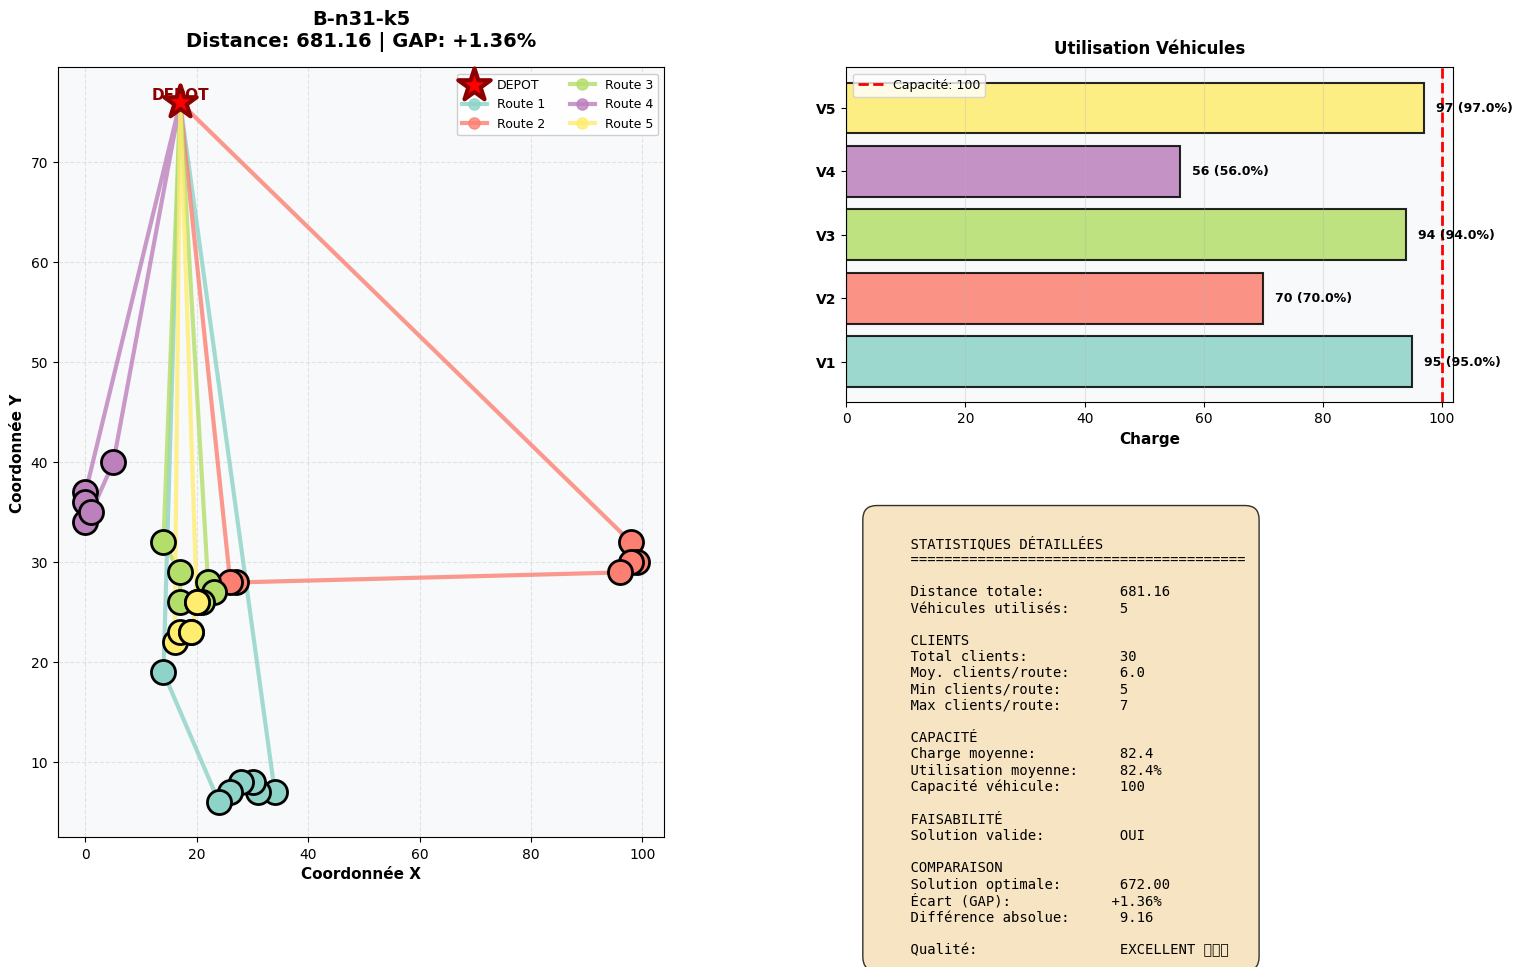

In [ ]:
# Visualisation graphique moderne
if solution:
    plot_solution(solution, title=INSTANCE_NAME, optimal_cost=optimal_cost)

In [70]:
# Visualisation Plotly interactive avec NetworkX
if solution:
    plot_solution(solution, title=INSTANCE_NAME, optimal_cost=optimal_cost)

Graphe NetworkX: 31 nœuds, 35 arêtes, Densité: 0.075


## Convergence Algorithme

In [ ]:
# Courbe de convergence avec comparaison optimal
if solution and 'history' in dir():
    # Récupérer l'historique via une nouvelle exécution rapide si nécessaire
    print("Affichage convergence...")

## Details Routes

## Instances Disponibles

**Petites (< 40 clients):**
- A-n32-k5 (32 clients, optimal: 784)
- B-n31-k5 (31 clients, optimal: 672)
- P-n16-k8 (16 clients)

**Moyennes (50-100 clients):**
- F-n72-k4 (72 clients, optimal: 237)
- tai75a (75 clients)

**Grandes (100+ clients):**
- M-n101-k10 (101 clients)
- X-n101-k25 (101 clients)
- Golden_1 (241 clients, optimal: 5627.54)
- ORTEC-n242-k12 (242 clients)

In [ ]:
# Comparaison détaillée avec le fichier .sol
if solution:
    sol_file = f"data/{INSTANCE_NAME}.sol"
    opt_cost, opt_routes = compare_with_optimal_solution(sol_file, solution)


╔══════════════════════════════════════════════════════════════════════════════╗
║                    COMPARAISON AVEC SOLUTION OPTIMALE                        ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─ FICHIER SOLUTION OPTIMALE ─────────────────────────────────────────────────┐
│ Fichier:                      data/B-n31-k5.sol                                  │
│ Nombre de routes:              5                                         │
│ Coût optimal:                       672.00                              │
└──────────────────────────────────────────────────────────────────────────────┘

┌─ ROUTES OPTIMALES ──────────────────────────────────────────────────────────┐
│ Route  1: [30, 23, 8, 12, 28, 26]                                        │
│ Route  2: [21, 16, 18, 25, 5, 4, 29]                                     │
│ Route  3: [7, 17, 13, 6, 9, 22]                                          │
│ Route  4: [20, 27, 10, 2]                 

## Comparaison Fichier .sol

In [ ]:
# Affichage détaillé de la solution
if solution:
    print_solution_details(solution, optimal_cost=optimal_cost)


╔══════════════════════════════════════════════════════════════════════════════╗
║                         SOLUTION VRP - DÉTAILS                               ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─ INFORMATIONS GÉNÉRALES ────────────────────────────────────────────────────┐
│ Distance totale:                    681.16                      │
│ Véhicules utilisés:            5 / 5                           │
│ Faisabilité:                              ✓ VALIDE          │
│ Solution optimale:                  672.00                      │
│ Écart (GAP):                          1.36%                     │
│ Différence absolue:                   9.16                      │
│ Qualité solution:                    ⭐⭐⭐ EXCELLENT          │
└──────────────────────────────────────────────────────────────────────────────┘

┌─ DÉTAILS DES ROUTES ────────────────────────────────────────────────────────┐
│                                             